# About this notebook

Siamese and contrastive loss can be used for signature verification by training a Siamese neural network to differentiate between genuine and forged signatures. The network consists of two identical branches, one for each of the two signatures being compared. The output of the two branches is then fed into a contrastive loss function, which calculates the difference between the two signatures and penalizes the network if the difference is too small (indicating that the signatures are likely to be genuine) or too large (indicating that the signatures are likely to be forged).

To improve the performance of the network, it is important to preprocess the signatures before training. This can include removing the background, centering the signature in a canvas, and resizing the signature to a fixed size (such as 170x242). These preprocessing steps can help to standardize the input to the network and make it easier for the network to learn the features that are important for signature verification.

# Acknowledgment
- This [link](https://github.com/luizgh/sigver) has the pretrained weights I used for my model. I also took the preprocessing functions.

In [1]:
!pip install -q --upgrade wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.7 which is incompatible.


# Load data

In [2]:
import pandas as pd
# Train data
train = pd.read_csv('../input/signature-verification-dataset/sign_data/train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")
train["image_forged_paths"] = train["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/train/{x}")

# Test data
test = pd.read_csv('../input/signature-verification-dataset/sign_data/test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["068/09_068.png"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")
test["image_forged_paths"] = test["068_forg/03_0113068.PNG"].apply(lambda x: f"../input/signature-verification-dataset/sign_data/test/{x}")

In [3]:
train["label"].value_counts(normalize=True)

0    0.543073
1    0.456927
Name: label, dtype: float64

In [4]:
test["label"].value_counts(normalize=True)

1    0.517661
0    0.482339
Name: label, dtype: float64

# Directory

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration

In [6]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=15
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=16
    lr=1e-3
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["label"].shape[0]
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    projection2d=False
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Libraries

In [7]:
import pandas as pd
import numpy as np
import wandb
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict


import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# W&B

In [8]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Signature", 
                 name="convnet",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: djoe. Use `wandb login --relogin` to force relogin


# utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# Data Pre-processing

In [10]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [11]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train.iloc[10]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

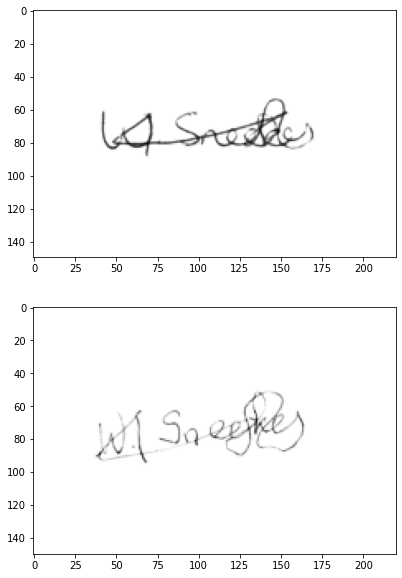

In [12]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

# Dataaset

In [13]:
class SignatureDataset(Dataset):
    
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label.float()

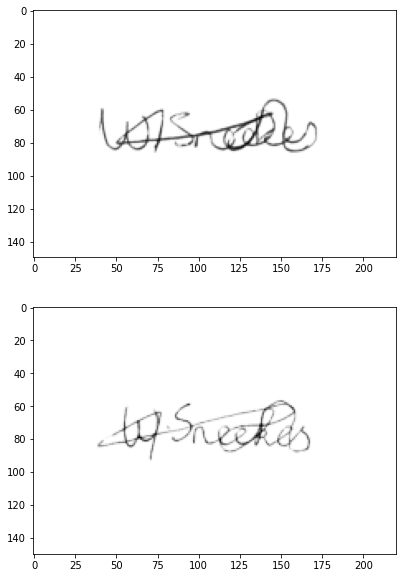

In [14]:
train_dataset = SignatureDataset(train, canvas_size, input_size)
img1, img2, _ = train_dataset[1]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

# Contrastive loss

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Models

In [16]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

class SiameseModel(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        state_dict, _, _ = torch.load("../input/pretrained-signature-weights/signet.pth")
        self.model.load_state_dict(state_dict)
        
        if CFG.projection2d:
            self.probs = nn.Linear(4, 1)
        else:
            self.probs = nn.Linear(self.model.feature_space_size*2, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)
        
        if CFG.projection2d:
            print("Project embeddings into 2d space")
            embedding1 = self.projection2d(embedding1)
            embedding2 = self.projection2d(embedding2)
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output
        else:
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

# Helper functions

In [17]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):
    
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2
            
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Elapsed: {timeSince(start, float(step+1)/len(train_loader))} ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: {CFG.lr}')
            
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
    return losses.avg

# train

In [18]:
# ====================================================
# loader
# ====================================================
seed_torch(seed=CFG.seed)


train_dataset = SignatureDataset(train, CFG.canvas_size, dim=(256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
   
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================
model = SiameseModel()
model.to(device)
    

optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
try:
    scheduler = get_scheduler(optimizer)
except:
    print('Learning scheduler is not used')

# ====================================================
# loop
# ====================================================
contrastive = ContrastiveLoss() # Contrastive loss
binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
best_score = 0.
best_loss = np.inf
    
for epoch in range(CFG.epochs):
        
    start_time = time.time()
        
    # train
    avg_loss = train_fn(train, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)

        
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, OneCycleLR):
        scheduler.step()


    elapsed = time.time() - start_time

    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
    wandb.log({f"epoch": epoch+1, 
                   f"avg_train_loss": avg_loss})
                 
            
    if avg_loss < best_loss:
        best_loss = avg_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict()}, 
                        OUTPUT_DIR+f'{CFG.model_name}_best_loss.pt')
   
   
wandb.finish()    

Epoch: [0][0/1450] Elapsed: 0m 11s (remain 286m 58s) Loss: 0.5396(0.5396) Grad: 4.1970 LR: 0.001000  
Epoch: [0][100/1450] Elapsed: 2m 16s (remain 30m 16s) Loss: 0.7056(0.4006) Grad: 4.0596 LR: 0.001000  
Epoch: [0][200/1450] Elapsed: 4m 6s (remain 25m 29s) Loss: 0.2683(0.3542) Grad: 2.4309 LR: 0.001000  
Epoch: [0][300/1450] Elapsed: 5m 55s (remain 22m 37s) Loss: 0.2178(0.3259) Grad: 1.7143 LR: 0.001000  
Epoch: [0][400/1450] Elapsed: 7m 44s (remain 20m 15s) Loss: 0.1790(0.3005) Grad: 1.3184 LR: 0.001000  
Epoch: [0][500/1450] Elapsed: 9m 32s (remain 18m 4s) Loss: 0.0801(0.2748) Grad: 0.7644 LR: 0.001000  
Epoch: [0][600/1450] Elapsed: 11m 22s (remain 16m 3s) Loss: 0.0744(0.2568) Grad: 0.9879 LR: 0.001000  
Epoch: [0][700/1450] Elapsed: 13m 11s (remain 14m 5s) Loss: 0.1103(0.2426) Grad: 1.1295 LR: 0.001000  
Epoch: [0][800/1450] Elapsed: 15m 0s (remain 12m 9s) Loss: 0.0473(0.2281) Grad: 1.4306 LR: 0.001000  
Epoch: [0][900/1450] Elapsed: 16m 49s (remain 10m 14s) Loss: 0.1545(0.2157) G

Epoch 1 - avg_train_loss: 0.1712  time: 1606s
Epoch 1 - Save Best Loss: 0.1712 Model


Epoch: [0][1449/1450] Elapsed: 26m 45s (remain 0m 0s) Loss: 0.0295(0.1712) Grad: 0.7177 LR: 0.001000  
Epoch: [1][0/1450] Elapsed: 0m 2s (remain 69m 41s) Loss: 0.0526(0.0526) Grad: 0.7207 LR: 0.000855  
Epoch: [1][100/1450] Elapsed: 1m 49s (remain 24m 24s) Loss: 0.0484(0.0699) Grad: 0.5197 LR: 0.000855  
Epoch: [1][200/1450] Elapsed: 3m 38s (remain 22m 35s) Loss: 0.0266(0.0678) Grad: 0.5340 LR: 0.000855  
Epoch: [1][300/1450] Elapsed: 5m 25s (remain 20m 41s) Loss: 0.1010(0.0750) Grad: 0.8348 LR: 0.000855  
Epoch: [1][400/1450] Elapsed: 7m 14s (remain 18m 55s) Loss: 0.0524(0.0732) Grad: 0.6413 LR: 0.000855  
Epoch: [1][500/1450] Elapsed: 9m 1s (remain 17m 6s) Loss: 0.0253(0.0674) Grad: 0.5785 LR: 0.000855  
Epoch: [1][600/1450] Elapsed: 10m 49s (remain 15m 17s) Loss: 0.0156(0.0653) Grad: 0.5447 LR: 0.000855  
Epoch: [1][700/1450] Elapsed: 12m 36s (remain 13m 28s) Loss: 0.0306(0.0655) Grad: 1.1374 LR: 0.000855  
Epoch: [1][800/1450] Elapsed: 14m 23s (remain 11m 39s) Loss: 0.0822(0.0640) 

Epoch 2 - avg_train_loss: 0.0574  time: 1564s
Epoch 2 - Save Best Loss: 0.0574 Model


Epoch: [1][1449/1450] Elapsed: 26m 3s (remain 0m 0s) Loss: 0.0410(0.0574) Grad: 0.9839 LR: 0.000855  
Epoch: [2][0/1450] Elapsed: 0m 3s (remain 75m 14s) Loss: 0.0412(0.0412) Grad: 1.4080 LR: 0.000505  
Epoch: [2][100/1450] Elapsed: 1m 50s (remain 24m 37s) Loss: 0.0205(0.0396) Grad: 0.7913 LR: 0.000505  
Epoch: [2][200/1450] Elapsed: 3m 37s (remain 22m 33s) Loss: 0.0146(0.0418) Grad: 0.3134 LR: 0.000505  
Epoch: [2][300/1450] Elapsed: 5m 25s (remain 20m 42s) Loss: 0.0087(0.0354) Grad: 0.1982 LR: 0.000505  
Epoch: [2][400/1450] Elapsed: 7m 13s (remain 18m 54s) Loss: 0.0107(0.0329) Grad: 0.3061 LR: 0.000505  
Epoch: [2][500/1450] Elapsed: 9m 1s (remain 17m 5s) Loss: 0.0105(0.0314) Grad: 0.1636 LR: 0.000505  
Epoch: [2][600/1450] Elapsed: 10m 48s (remain 15m 16s) Loss: 0.1729(0.0315) Grad: 1.7188 LR: 0.000505  
Epoch: [2][700/1450] Elapsed: 12m 35s (remain 13m 27s) Loss: 0.0128(0.0303) Grad: 0.1986 LR: 0.000505  
Epoch: [2][800/1450] Elapsed: 14m 23s (remain 11m 39s) Loss: 0.0420(0.0297) G

Epoch 3 - avg_train_loss: 0.0308  time: 1557s
Epoch 3 - Save Best Loss: 0.0308 Model


Epoch: [2][1449/1450] Elapsed: 25m 56s (remain 0m 0s) Loss: 0.0379(0.0308) Grad: 1.1205 LR: 0.000505  
Epoch: [3][0/1450] Elapsed: 0m 2s (remain 59m 31s) Loss: 0.0324(0.0324) Grad: 1.0173 LR: 0.000155  
Epoch: [3][100/1450] Elapsed: 1m 50s (remain 24m 36s) Loss: 0.0222(0.0255) Grad: 0.6102 LR: 0.000155  
Epoch: [3][200/1450] Elapsed: 3m 37s (remain 22m 33s) Loss: 0.0307(0.0212) Grad: 0.9116 LR: 0.000155  
Epoch: [3][300/1450] Elapsed: 5m 24s (remain 20m 40s) Loss: 0.0171(0.0213) Grad: 0.7036 LR: 0.000155  
Epoch: [3][400/1450] Elapsed: 7m 11s (remain 18m 49s) Loss: 0.0159(0.0201) Grad: 0.5226 LR: 0.000155  
Epoch: [3][500/1450] Elapsed: 8m 59s (remain 17m 2s) Loss: 0.0102(0.0189) Grad: 0.3201 LR: 0.000155  
Epoch: [3][600/1450] Elapsed: 10m 46s (remain 15m 12s) Loss: 0.0129(0.0182) Grad: 0.3922 LR: 0.000155  
Epoch: [3][700/1450] Elapsed: 12m 32s (remain 13m 24s) Loss: 0.0078(0.0176) Grad: 0.1718 LR: 0.000155  
Epoch: [3][800/1450] Elapsed: 14m 19s (remain 11m 36s) Loss: 0.0232(0.0172)

Epoch 4 - avg_train_loss: 0.0171  time: 1553s
Epoch 4 - Save Best Loss: 0.0171 Model


Epoch: [3][1449/1450] Elapsed: 25m 53s (remain 0m 0s) Loss: 0.0345(0.0171) Grad: 0.5733 LR: 0.000155  
Epoch: [4][0/1450] Elapsed: 0m 2s (remain 56m 30s) Loss: 0.0152(0.0152) Grad: 0.3062 LR: 0.000010  
Epoch: [4][100/1450] Elapsed: 1m 50s (remain 24m 38s) Loss: 0.0051(0.0144) Grad: 0.1909 LR: 0.000010  
Epoch: [4][200/1450] Elapsed: 3m 36s (remain 22m 27s) Loss: 0.0057(0.0136) Grad: 0.2332 LR: 0.000010  
Epoch: [4][300/1450] Elapsed: 5m 24s (remain 20m 38s) Loss: 0.0049(0.0136) Grad: 0.1462 LR: 0.000010  
Epoch: [4][400/1450] Elapsed: 7m 12s (remain 18m 51s) Loss: 0.0038(0.0135) Grad: 0.0862 LR: 0.000010  
Epoch: [4][500/1450] Elapsed: 9m 0s (remain 17m 4s) Loss: 0.0244(0.0132) Grad: 0.8115 LR: 0.000010  
Epoch: [4][600/1450] Elapsed: 10m 49s (remain 15m 16s) Loss: 0.0073(0.0138) Grad: 0.3193 LR: 0.000010  
Epoch: [4][700/1450] Elapsed: 12m 37s (remain 13m 29s) Loss: 0.0094(0.0137) Grad: 0.2690 LR: 0.000010  
Epoch: [4][800/1450] Elapsed: 14m 26s (remain 11m 41s) Loss: 0.0236(0.0136) 

Epoch 5 - avg_train_loss: 0.0135  time: 1574s
Epoch 5 - Save Best Loss: 0.0135 Model


Epoch: [4][1449/1450] Elapsed: 26m 13s (remain 0m 0s) Loss: 0.0062(0.0135) Grad: 0.1947 LR: 0.000010  
Epoch: [5][0/1450] Elapsed: 0m 2s (remain 60m 34s) Loss: 0.0114(0.0114) Grad: 0.3063 LR: 0.000155  
Epoch: [5][100/1450] Elapsed: 1m 51s (remain 24m 46s) Loss: 0.0250(0.0202) Grad: 0.4091 LR: 0.000155  
Epoch: [5][200/1450] Elapsed: 3m 40s (remain 22m 53s) Loss: 0.0084(0.0174) Grad: 0.1809 LR: 0.000155  
Epoch: [5][300/1450] Elapsed: 5m 28s (remain 20m 55s) Loss: 0.0217(0.0167) Grad: 0.5625 LR: 0.000155  
Epoch: [5][400/1450] Elapsed: 7m 18s (remain 19m 7s) Loss: 0.0085(0.0156) Grad: 0.3130 LR: 0.000155  
Epoch: [5][500/1450] Elapsed: 9m 7s (remain 17m 17s) Loss: 0.0062(0.0148) Grad: 0.1671 LR: 0.000155  
Epoch: [5][600/1450] Elapsed: 10m 57s (remain 15m 29s) Loss: 0.0129(0.0143) Grad: 0.3715 LR: 0.000155  
Epoch: [5][700/1450] Elapsed: 12m 47s (remain 13m 39s) Loss: 0.0092(0.0140) Grad: 0.2651 LR: 0.000155  
Epoch: [5][800/1450] Elapsed: 14m 37s (remain 11m 51s) Loss: 0.0078(0.0139) 

Epoch 6 - avg_train_loss: 0.0136  time: 1588s


Epoch: [5][1449/1450] Elapsed: 26m 27s (remain 0m 0s) Loss: 0.0063(0.0136) Grad: 0.1639 LR: 0.000155  
Epoch: [6][0/1450] Elapsed: 0m 2s (remain 56m 42s) Loss: 0.0117(0.0117) Grad: 0.4804 LR: 0.000505  
Epoch: [6][100/1450] Elapsed: 1m 51s (remain 24m 48s) Loss: 0.1288(0.1583) Grad: 1.4392 LR: 0.000505  
Epoch: [6][200/1450] Elapsed: 3m 39s (remain 22m 42s) Loss: 0.3956(0.1178) Grad: 6.3059 LR: 0.000505  
Epoch: [6][300/1450] Elapsed: 5m 30s (remain 20m 59s) Loss: 0.0242(0.1027) Grad: 0.3087 LR: 0.000505  
Epoch: [6][400/1450] Elapsed: 7m 19s (remain 19m 8s) Loss: 0.0208(0.0849) Grad: 0.4888 LR: 0.000505  
Epoch: [6][500/1450] Elapsed: 9m 8s (remain 17m 19s) Loss: 0.0145(0.0734) Grad: 0.3641 LR: 0.000505  
Epoch: [6][600/1450] Elapsed: 10m 57s (remain 15m 29s) Loss: 0.0529(0.0642) Grad: 1.2636 LR: 0.000505  
Epoch: [6][700/1450] Elapsed: 12m 46s (remain 13m 39s) Loss: 0.0199(0.0584) Grad: 0.2826 LR: 0.000505  
Epoch: [6][800/1450] Elapsed: 14m 36s (remain 11m 50s) Loss: 0.0180(0.0540) 

Epoch 7 - avg_train_loss: 0.0399  time: 1585s


Epoch: [6][1449/1450] Elapsed: 26m 25s (remain 0m 0s) Loss: 0.0151(0.0399) Grad: 0.7635 LR: 0.000505  
Epoch: [7][0/1450] Elapsed: 0m 2s (remain 56m 10s) Loss: 0.0124(0.0124) Grad: 0.2254 LR: 0.000855  
Epoch: [7][100/1450] Elapsed: 1m 52s (remain 25m 3s) Loss: 0.0455(0.0979) Grad: 0.8221 LR: 0.000855  
Epoch: [7][200/1450] Elapsed: 3m 39s (remain 22m 41s) Loss: 0.1103(0.0794) Grad: 2.5660 LR: 0.000855  
Epoch: [7][300/1450] Elapsed: 5m 26s (remain 20m 44s) Loss: 0.0356(0.0772) Grad: 0.9109 LR: 0.000855  
Epoch: [7][400/1450] Elapsed: 7m 14s (remain 18m 57s) Loss: 0.0280(0.0702) Grad: 0.5236 LR: 0.000855  
Epoch: [7][500/1450] Elapsed: 9m 1s (remain 17m 5s) Loss: 0.0266(0.0616) Grad: 0.4433 LR: 0.000855  
Epoch: [7][600/1450] Elapsed: 10m 48s (remain 15m 16s) Loss: 0.0330(0.0606) Grad: 1.0494 LR: 0.000855  
Epoch: [7][700/1450] Elapsed: 12m 35s (remain 13m 27s) Loss: 0.0171(0.0562) Grad: 0.4360 LR: 0.000855  
Epoch: [7][800/1450] Elapsed: 14m 23s (remain 11m 39s) Loss: 0.0116(0.0534) G

Epoch 8 - avg_train_loss: 0.0410  time: 1562s


Epoch: [7][1449/1450] Elapsed: 26m 1s (remain 0m 0s) Loss: 0.0122(0.0410) Grad: 0.2139 LR: 0.000855  
Epoch: [8][0/1450] Elapsed: 0m 2s (remain 55m 11s) Loss: 0.0413(0.0413) Grad: 0.8421 LR: 0.001000  
Epoch: [8][100/1450] Elapsed: 1m 50s (remain 24m 42s) Loss: 0.0991(0.0413) Grad: 2.0499 LR: 0.001000  
Epoch: [8][200/1450] Elapsed: 3m 40s (remain 22m 49s) Loss: 0.0628(0.0571) Grad: 2.7622 LR: 0.001000  
Epoch: [8][300/1450] Elapsed: 5m 28s (remain 20m 55s) Loss: 0.0390(0.0565) Grad: 0.7684 LR: 0.001000  
Epoch: [8][400/1450] Elapsed: 7m 17s (remain 19m 5s) Loss: 0.0148(0.0532) Grad: 0.3084 LR: 0.001000  
Epoch: [8][500/1450] Elapsed: 9m 6s (remain 17m 15s) Loss: 0.0127(0.0499) Grad: 0.4424 LR: 0.001000  
Epoch: [8][600/1450] Elapsed: 10m 55s (remain 15m 25s) Loss: 0.0313(0.0457) Grad: 1.1987 LR: 0.001000  
Epoch: [8][700/1450] Elapsed: 12m 43s (remain 13m 35s) Loss: 0.0820(0.0432) Grad: 1.2127 LR: 0.001000  
Epoch: [8][800/1450] Elapsed: 14m 32s (remain 11m 46s) Loss: 0.0121(0.0402) G

Epoch 9 - avg_train_loss: 0.0370  time: 1583s


Epoch: [8][1449/1450] Elapsed: 26m 22s (remain 0m 0s) Loss: 0.0139(0.0370) Grad: 0.2574 LR: 0.001000  
Epoch: [9][0/1450] Elapsed: 0m 2s (remain 60m 55s) Loss: 0.0121(0.0121) Grad: 0.2635 LR: 0.000855  
Epoch: [9][100/1450] Elapsed: 1m 52s (remain 25m 5s) Loss: 0.0083(0.0338) Grad: 0.1922 LR: 0.000855  
Epoch: [9][200/1450] Elapsed: 3m 41s (remain 22m 55s) Loss: 0.0186(0.0287) Grad: 0.1892 LR: 0.000855  
Epoch: [9][300/1450] Elapsed: 5m 28s (remain 20m 54s) Loss: 0.0061(0.0281) Grad: 0.1431 LR: 0.000855  
Epoch: [9][400/1450] Elapsed: 7m 18s (remain 19m 6s) Loss: 0.0094(0.0255) Grad: 0.1963 LR: 0.000855  
Epoch: [9][500/1450] Elapsed: 9m 6s (remain 17m 15s) Loss: 0.0206(0.0227) Grad: 0.6764 LR: 0.000855  
Epoch: [9][600/1450] Elapsed: 10m 55s (remain 15m 26s) Loss: 0.0053(0.0220) Grad: 0.1294 LR: 0.000855  
Epoch: [9][700/1450] Elapsed: 12m 44s (remain 13m 36s) Loss: 0.0494(0.0236) Grad: 1.8798 LR: 0.000855  
Epoch: [9][800/1450] Elapsed: 14m 30s (remain 11m 45s) Loss: 0.0113(0.0230) G

Epoch 10 - avg_train_loss: 0.0275  time: 1565s


Epoch: [9][1449/1450] Elapsed: 26m 5s (remain 0m 0s) Loss: 0.0210(0.0275) Grad: 0.8497 LR: 0.000855  
Epoch: [10][0/1450] Elapsed: 0m 2s (remain 56m 55s) Loss: 0.0073(0.0073) Grad: 0.1496 LR: 0.000505  
Epoch: [10][100/1450] Elapsed: 1m 49s (remain 24m 17s) Loss: 0.0254(0.0185) Grad: 1.0205 LR: 0.000505  
Epoch: [10][200/1450] Elapsed: 3m 35s (remain 22m 21s) Loss: 0.0041(0.0171) Grad: 0.0878 LR: 0.000505  
Epoch: [10][300/1450] Elapsed: 5m 22s (remain 20m 30s) Loss: 0.0717(0.0154) Grad: 1.0752 LR: 0.000505  
Epoch: [10][400/1450] Elapsed: 7m 9s (remain 18m 42s) Loss: 0.0203(0.0219) Grad: 0.3819 LR: 0.000505  
Epoch: [10][500/1450] Elapsed: 8m 56s (remain 16m 55s) Loss: 0.0155(0.0212) Grad: 0.3153 LR: 0.000505  
Epoch: [10][600/1450] Elapsed: 10m 43s (remain 15m 9s) Loss: 0.1130(0.0215) Grad: 2.3280 LR: 0.000505  
Epoch: [10][700/1450] Elapsed: 12m 30s (remain 13m 21s) Loss: 0.0043(0.0206) Grad: 0.0933 LR: 0.000505  
Epoch: [10][800/1450] Elapsed: 14m 17s (remain 11m 34s) Loss: 0.0083(

Epoch 11 - avg_train_loss: 0.0175  time: 1551s


Epoch: [10][1449/1450] Elapsed: 25m 51s (remain 0m 0s) Loss: 0.0268(0.0175) Grad: 1.0339 LR: 0.000505  
Epoch: [11][0/1450] Elapsed: 0m 2s (remain 54m 11s) Loss: 0.0058(0.0058) Grad: 0.2049 LR: 0.000155  
Epoch: [11][100/1450] Elapsed: 1m 49s (remain 24m 27s) Loss: 0.0076(0.0124) Grad: 0.2314 LR: 0.000155  
Epoch: [11][200/1450] Elapsed: 3m 38s (remain 22m 35s) Loss: 0.0134(0.0138) Grad: 0.5660 LR: 0.000155  
Epoch: [11][300/1450] Elapsed: 5m 26s (remain 20m 47s) Loss: 0.0341(0.0129) Grad: 3.2615 LR: 0.000155  
Epoch: [11][400/1450] Elapsed: 7m 16s (remain 19m 2s) Loss: 0.0121(0.0123) Grad: 0.2461 LR: 0.000155  
Epoch: [11][500/1450] Elapsed: 9m 5s (remain 17m 14s) Loss: 0.0087(0.0118) Grad: 0.1305 LR: 0.000155  
Epoch: [11][600/1450] Elapsed: 10m 55s (remain 15m 26s) Loss: 0.0115(0.0115) Grad: 0.2385 LR: 0.000155  
Epoch: [11][700/1450] Elapsed: 12m 43s (remain 13m 35s) Loss: 0.0038(0.0115) Grad: 0.1478 LR: 0.000155  
Epoch: [11][800/1450] Elapsed: 14m 30s (remain 11m 45s) Loss: 0.005

Epoch 12 - avg_train_loss: 0.0104  time: 1573s
Epoch 12 - Save Best Loss: 0.0104 Model


Epoch: [11][1449/1450] Elapsed: 26m 12s (remain 0m 0s) Loss: 0.0032(0.0104) Grad: 0.0608 LR: 0.000155  
Epoch: [12][0/1450] Elapsed: 0m 2s (remain 55m 37s) Loss: 0.0078(0.0078) Grad: 0.3096 LR: 0.000010  
Epoch: [12][100/1450] Elapsed: 1m 51s (remain 24m 44s) Loss: 0.0067(0.0078) Grad: 0.1998 LR: 0.000010  
Epoch: [12][200/1450] Elapsed: 3m 38s (remain 22m 40s) Loss: 0.0674(0.0083) Grad: 2.2987 LR: 0.000010  
Epoch: [12][300/1450] Elapsed: 5m 26s (remain 20m 48s) Loss: 0.0059(0.0088) Grad: 0.0780 LR: 0.000010  
Epoch: [12][400/1450] Elapsed: 7m 13s (remain 18m 54s) Loss: 0.0082(0.0086) Grad: 0.4198 LR: 0.000010  
Epoch: [12][500/1450] Elapsed: 9m 1s (remain 17m 6s) Loss: 0.0030(0.0090) Grad: 0.0597 LR: 0.000010  
Epoch: [12][600/1450] Elapsed: 10m 50s (remain 15m 18s) Loss: 0.0032(0.0117) Grad: 0.0905 LR: 0.000010  
Epoch: [12][700/1450] Elapsed: 12m 37s (remain 13m 28s) Loss: 0.0031(0.0111) Grad: 0.0909 LR: 0.000010  
Epoch: [12][800/1450] Elapsed: 14m 25s (remain 11m 41s) Loss: 0.003

Epoch 13 - avg_train_loss: 0.0099  time: 1558s
Epoch 13 - Save Best Loss: 0.0099 Model


Epoch: [12][1449/1450] Elapsed: 25m 58s (remain 0m 0s) Loss: 0.0068(0.0099) Grad: 0.2554 LR: 0.000010  
Epoch: [13][0/1450] Elapsed: 0m 2s (remain 54m 46s) Loss: 0.0082(0.0082) Grad: 0.2224 LR: 0.000155  
Epoch: [13][100/1450] Elapsed: 1m 50s (remain 24m 34s) Loss: 0.0053(0.0079) Grad: 0.1248 LR: 0.000155  
Epoch: [13][200/1450] Elapsed: 3m 36s (remain 22m 27s) Loss: 0.0139(0.0078) Grad: 0.3436 LR: 0.000155  
Epoch: [13][300/1450] Elapsed: 5m 23s (remain 20m 35s) Loss: 0.0047(0.0077) Grad: 0.0619 LR: 0.000155  
Epoch: [13][400/1450] Elapsed: 7m 12s (remain 18m 50s) Loss: 0.0076(0.0077) Grad: 0.3858 LR: 0.000155  
Epoch: [13][500/1450] Elapsed: 8m 59s (remain 17m 1s) Loss: 0.0074(0.0078) Grad: 0.2309 LR: 0.000155  
Epoch: [13][600/1450] Elapsed: 10m 48s (remain 15m 15s) Loss: 0.0051(0.0078) Grad: 0.1149 LR: 0.000155  
Epoch: [13][700/1450] Elapsed: 12m 35s (remain 13m 26s) Loss: 0.0052(0.0080) Grad: 0.1957 LR: 0.000155  
Epoch: [13][800/1450] Elapsed: 14m 20s (remain 11m 37s) Loss: 0.00

Epoch 14 - avg_train_loss: 0.0080  time: 1549s
Epoch 14 - Save Best Loss: 0.0080 Model


Epoch: [13][1449/1450] Elapsed: 25m 49s (remain 0m 0s) Loss: 0.0030(0.0080) Grad: 0.0851 LR: 0.000155  
Epoch: [14][0/1450] Elapsed: 0m 2s (remain 53m 36s) Loss: 0.0051(0.0051) Grad: 0.1165 LR: 0.000505  
Epoch: [14][100/1450] Elapsed: 1m 48s (remain 24m 3s) Loss: 0.0083(0.0106) Grad: 0.2117 LR: 0.000505  
Epoch: [14][200/1450] Elapsed: 3m 32s (remain 22m 0s) Loss: 0.0600(0.0476) Grad: 1.6605 LR: 0.000505  
Epoch: [14][300/1450] Elapsed: 5m 17s (remain 20m 12s) Loss: 0.0239(0.0396) Grad: 0.4031 LR: 0.000505  
Epoch: [14][400/1450] Elapsed: 7m 3s (remain 18m 28s) Loss: 0.0177(0.0341) Grad: 0.8214 LR: 0.000505  
Epoch: [14][500/1450] Elapsed: 8m 48s (remain 16m 41s) Loss: 0.0078(0.0317) Grad: 0.2352 LR: 0.000505  
Epoch: [14][600/1450] Elapsed: 10m 34s (remain 14m 55s) Loss: 0.0070(0.0291) Grad: 0.1677 LR: 0.000505  
Epoch: [14][700/1450] Elapsed: 12m 21s (remain 13m 12s) Loss: 0.0165(0.0274) Grad: 1.0350 LR: 0.000505  
Epoch: [14][800/1450] Elapsed: 14m 6s (remain 11m 26s) Loss: 0.0186(

Epoch 15 - avg_train_loss: 0.0246  time: 1536s


Epoch: [14][1449/1450] Elapsed: 25m 35s (remain 0m 0s) Loss: 0.0139(0.0246) Grad: 0.3526 LR: 0.000505  


[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... image_forged_paths 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... [23205 rows x 5 columns]] loss,█▆▄▃▂▂▁▃▂▁▁▁▂▄▁▁▂▁▁▁▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... image_forged_paths 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/sign_d... 2 ../input/signature-verification-dataset/sign_d... 3 ../input/signature-verification-dataset/sign_d... 4 ../input/signature-verification-dataset/sign_d... ... ... 23200 ../input/signature-verification-dataset/sign_d... 23201 ../input/signature-verification-dataset/sign_d... 23202 ../input/signature-verification-dataset/sign_d... 23203 ../input/signature-verification-dataset/sign_d... 23204 ../input/signature-verification-dataset/sign_d... [23205 rows x 5 columns]] lr,███▇▇▇▄▄▂▂▂▁▁▁▂▂▄▄▄▇▇▇██▇▇▇▄▄▄▂▂▁▁▁▂▂▂▄▄
avg_train_loss,█▃▂▁▁▁▂▂▂▂▁▁▁▁▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
[fold 068/09_068.png 068_forg/03_0113068.PNG label \ 0 068/09_068.png 068_forg/01_0124068.PNG 1 1 068/09_068.png 068_forg/02_0124068.PNG 1 2 068/09_068.png 068_forg/01_0113068.PNG 1 3 068/09_068.png 068_forg/04_0124068.PNG 1 4 068/09_068.png 068_forg/04_0113068.PNG 1 ... ... ... ... 23200 031/02_031.png 031/03_031.png 0 23201 031/02_031.png 031/12_031.png 0 23202 031/02_031.png 031/11_031.png 0 23203 031/02_031.png 031/06_031.png 0 23204 031/02_031.png 031/07_031.png 0 image_real_paths \ 0 ../input/signature-verification-dataset/sign_d... 1 ../input/signature-verification-dataset/si

# Inference

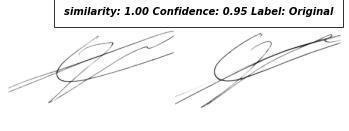

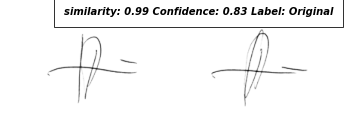

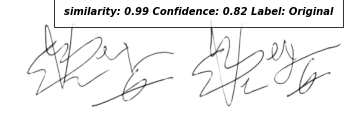

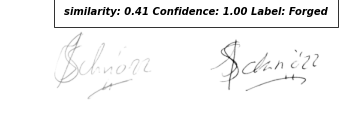

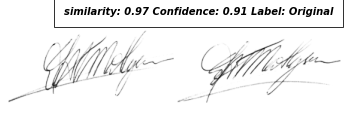

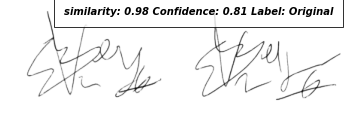

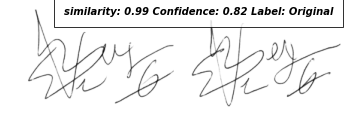

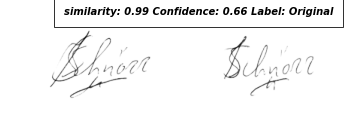

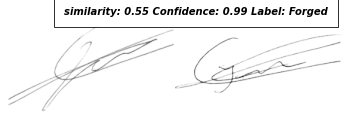

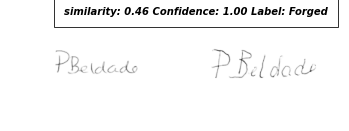

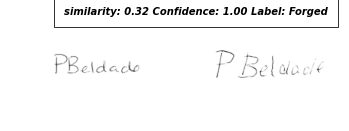

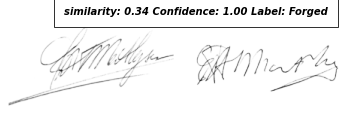

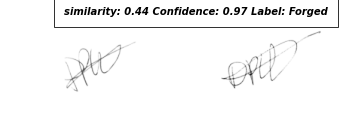

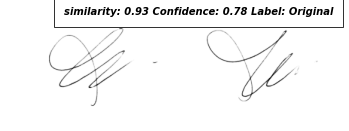

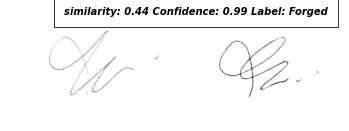

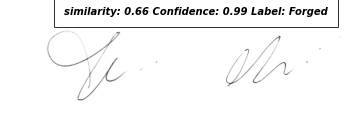

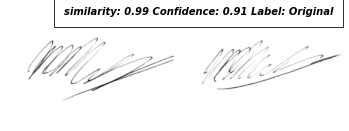

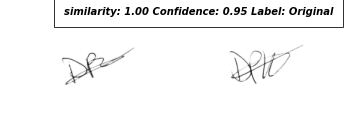

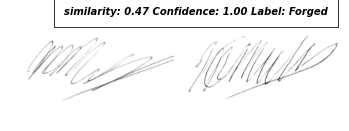

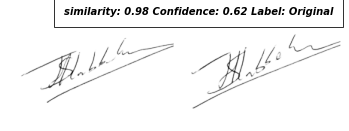

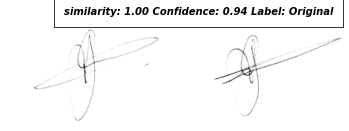

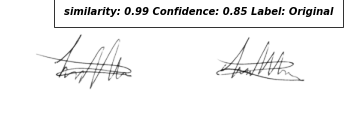

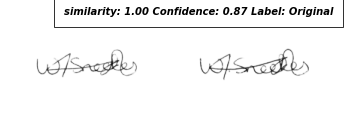

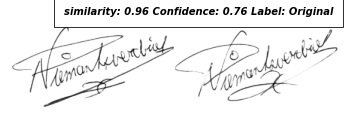

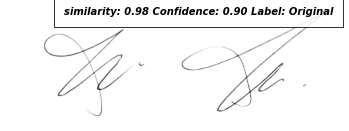

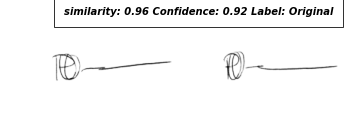

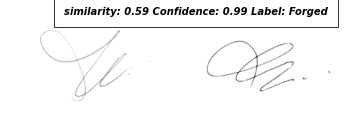

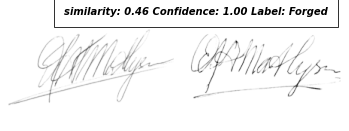

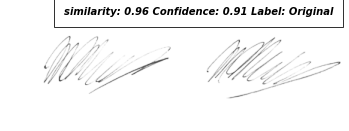

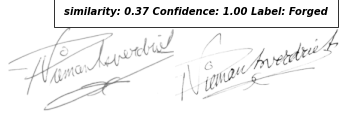

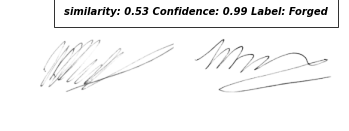

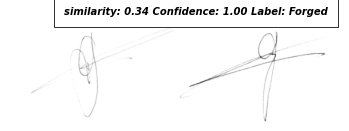

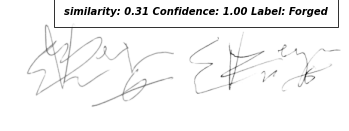

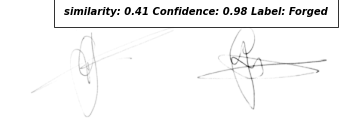

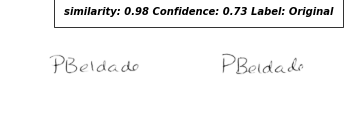

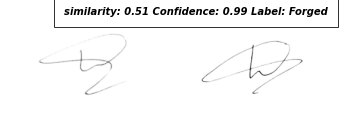

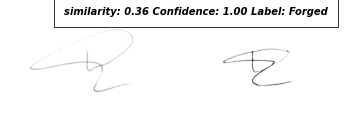

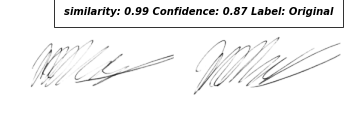

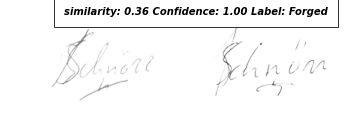

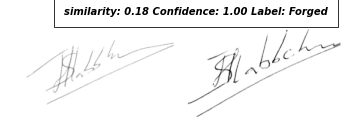

<Figure size 432x288 with 0 Axes>

In [19]:
seed_torch(seed=CFG.seed)
model = SiameseModel()
model.load_state_dict(torch.load('./convnet_best_loss.pt')['model'])


test_dataset = SignatureDataset(test, CFG.canvas_size, dim=(256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

counter = 0 
label_dict = {1.0:'Forged', 0.0:'Original'}
CFG.projection2d=False
model.eval()
for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    concatenated = torch.cat((img1, img2),0)
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')
    if label == 0.0:
        confidence = 1 - confidence
    cos_sim = F.cosine_similarity(op1, op2)

    imshow(torchvision.utils.make_grid(concatenated.unsqueeze(1)), f'similarity: {cos_sim.item():.2f} Confidence: {confidence.item():.2f} Label: {label_dict[label.item()]}')
    plt.savefig('siamese.png')
    counter+=1
    if counter==40:
        break